In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import time
from matplotlib.animation import FuncAnimation
import time

class SpectrumEnvironment:
    def __init__(self, num_bands=10, steps=25,detection_method="energy_detection"):
        self.num_bands = num_bands  # Total number of frequency bands
        self.steps = steps
        self.channel_states = [[] for _ in range(num_bands)]
        self.transition_matrices = self._initialize_transition_matrices()
        self.total_reward = 0  # Track total reward
        self.rewards = []  # Track rewards for each step
        self.energy_costs = [[] for _ in range(num_bands)]
        self.total_energy = 0
        valid_methods = ["energy_detection", "matched_filter", "cyclostationary"]
        if detection_method not in valid_methods:
            raise ValueError(f"Invalid detection method. Choose from {valid_methods}")
        self.detection_method = detection_method
        self.state = self._generate_spectrum_state()  # Current state of the spectrum
        self.energy_detection_count = 0
    def _initialize_transition_matrices(self):
        """
        Generate a unique random Markov chain transition matrix for each band.
        Each matrix ensures that the probabilities in each row sum to 1.
        """
        matrices = []
        for _ in range(self.num_bands):
            # Generate a random 2x2 matrix
            random_matrix = np.random.rand(2, 2)
            # Normalize each row to sum to 1
            transition_matrix = random_matrix / random_matrix.sum(axis=1, keepdims=True)
            matrices.append(transition_matrix)
        return matrices
    
    def threshold_calculator(self,time_step):
        t = 0
        c = 0
        for i in range(self.num_bands):
            if len(self.energy_costs[i]) == 0:
                pass
            else:
                t+= self.energy_costs[i][-1]
                c+=1
        if c != 0:
            t = t/c
        return t
    def energy_detection(self, time_step, band, delta=0.1, noise_floor=0.05):
        """
        Perform energy detection for a specific band and timestep.
        Simulates energy detection with a noise floor threshold.
    
        Parameters:
        - time_step (int): The timestep to evaluate.
        - band (int): The band (channel) number to evaluate.
        - delta (float): The change in energy state for transitions (default: 0.1).
        - noise_floor (float): The noise floor threshold for detection (default: 0.05).
    
        Returns:
        - detection_result (int): 1 if channel is occupied, 0 otherwise.
        - energy (float): Calculated energy for the band and timestep.
        """
        # Ensure valid inputs
        if not (0 <= band < self.num_bands):
            raise ValueError("Band number out of range.")
        if not (0 <= time_step < self.steps):
            raise ValueError("Time step out of range.")
    
        # Current state and previous energy
        current_state = self.channel_states[band][time_step]
        previous_energy = self.energy_costs[band][-1] if self.energy_costs[band] else 0
    
        # Calculate new energy state
        new_energy = previous_energy + (delta if current_state == 1 else 0)
        self.energy_costs[band].append(new_energy)
    
        # Detection decision
        nr = self.threshold_calculator(time_step)
        detection_result = 1 if new_energy >= nr else 0
        return detection_result, new_energy

    def detect(self,time_step,band):
        if self.detection_method == "energy_detection":
            return self.energy_detection(time_step, band)
        elif self.detection_method == "matched_filter":
            pass
        elif self.detection_method == "cyclostationary":
            pass
    
    def _generate_spectrum_state(self):
        """
        Generate or regenerate spectrum states for all bands using Markov chain dynamics.
        Ensures a clean slate to avoid unintended accumulation of states.
        """
        # Clear existing states to ensure consistent initialization
        self.channel_states = [[] for _ in range(self.num_bands)]
        
        for band in range(self.num_bands):
            last_state = 0  # Start with a default state
            band_states = []
            
            for time_step in range(self.steps):
                # Determine the next state based on the Markov chain
                transition_probabilities = self.transition_matrices[band][last_state]
                next_state = np.random.choice([0, 1], p=transition_probabilities)
                band_states.append(next_state)
                last_state = next_state  # Update for the next step
            
            self.channel_states[band] = band_states
    
        return self.channel_states

    
    def step(self, time_step, action):
        """
        Execute an action, calculate reward, and return the next state, reward, and done flag.
    
        Parameters:
        - time_step (int): The current time step in the simulation.
        - action (int): The chosen action (index corresponds to detect/skip for each band).
    
        Returns:
        - next_state (tuple): The next state after performing the action.
        - reward (float): The reward for the action taken.
        - done (bool): Whether the episode has ended.
        """
        # Decode action into band and operation (detect/skip)
        num_actions_per_band = 2  # Detect or Skip
        band = action // num_actions_per_band
        operation = action % num_actions_per_band  # 0: Detect, 1: Skip
        raw_reward = 30 if self.channel_states[band][time_step] == 0 else 5
        
        if not (0 <= band < self.num_bands):
            raise ValueError("Band number out of range.")
        if not (0 <= time_step < self.steps):
            raise ValueError("Time step out of range.")
    
        # If "Skip," return a small penalty and proceed
        if operation == 1:  # Skip
            reward = raw_reward  # Small penalty for skipping
            next_state = (time_step + 1,) if time_step + 1 < self.steps else (self.steps - 1,)
            done = time_step + 1 >= self.steps
            return next_state, reward, done
    
        # "Detect" operation
        self.energy_detection_count += 1
        detection_result, energy_consumption = self.detect(time_step, band)
        if detection_result and self.channel_states[band][time_step] == 0:
            reward = raw_reward - energy_consumption
        elif not detection_result and self.channel_states[band] == 0:
            reward = raw_reward - energy_consumption
        else:
            reward = -raw_reward - energy_consumption
        # Update total reward
        self.total_reward += reward
        self.total_energy += energy_consumption
        # Calculate next state
        next_time_step = time_step + 1
        next_state = (next_time_step,) if next_time_step < self.steps else (self.steps - 1,)
        done = next_time_step >= self.steps
    
        return next_state, reward, done

    
    def soft_reset(self):
        self.energy_costs = [[] for _ in range(self.num_bands)]
        self.total_energy = 0
        self.energy_detection_count = 0

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, action_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=-1)

class REINFORCE:
    def __init__(self, state_dim, action_dim, learning_rate=0.001, gamma=0.99):
        self.gamma = gamma
        self.policy = PolicyNetwork(state_dim, action_dim)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=learning_rate)
        self.saved_log_probs = []
        self.rewards = []
        
    def select_action(self, state):
        state = torch.FloatTensor(state)
        probs = self.policy(state)
        m = Categorical(probs)
        action = m.sample()
        self.saved_log_probs.append(m.log_prob(action))
        return action.item()
        
    def update(self):
        # Guard against empty rewards list
        if len(self.rewards) == 0:
            print("Warning: No rewards collected in this episode")
            self.saved_log_probs = []
            return
        
        # Convert log_probs to tensor and check for issues
        if len(self.saved_log_probs) == 0:
            print("Warning: No log probabilities collected in this episode")
            self.rewards = []
            return
            
        # Make sure saved_log_probs and rewards match in length
        if len(self.saved_log_probs) != len(self.rewards):
            print(f"Warning: Mismatch between log_probs ({len(self.saved_log_probs)}) and rewards ({len(self.rewards)})")
            min_len = min(len(self.saved_log_probs), len(self.rewards))
            self.saved_log_probs = self.saved_log_probs[:min_len]
            self.rewards = self.rewards[:min_len]
            
        R = 0
        policy_loss = []
        returns = []
        
        # Calculate returns
        for r in self.rewards[::-1]:
            R = r + self.gamma * R
            returns.insert(0, R)
            
        returns = torch.FloatTensor(returns)
        
        # Handle case where all returns are the same (avoiding division by zero)
        if returns.std() == 0:
            returns = returns - returns.mean()
        else:
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        
        # Calculate policy loss - ensure tensors
        for i, (log_prob, R) in enumerate(zip(self.saved_log_probs, returns)):
            policy_loss.append(log_prob * (-R))  # Note: simplified to avoid potential issues
        
        # Use stack instead of cat for more explicit error messages
        try:
            policy_loss = torch.stack(policy_loss).sum()
        except RuntimeError as e:
            print(f"Error stacking policy losses: {e}")
            print(f"Types in policy_loss: {[type(p) for p in policy_loss]}")
            self.saved_log_probs = []
            self.rewards = []
            return
            
        # Update policy network
        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()
        
        # Clear memory
        self.saved_log_probs = []
        self.rewards = []

def train_reinforce(env, episodes=1000, state_dim=11, gamma=0.99):
    """
    Train using REINFORCE algorithm (Policy Gradient)
    
    Args:
        env: The SpectrumEnvironment instance
        episodes: Number of episodes to train
        state_dim: Dimension of state (num_bands + 1 for time step)
        gamma: Discount factor
    
    Returns:
        List of episode rewards
    """
    # Number of actions: detect or skip for each band
    action_dim = env.num_bands * 2
    
    # Initialize the agent
    agent = REINFORCE(state_dim, action_dim, gamma=gamma)
    
    episode_rewards = []
    
    for episode in range(episodes):
        # Reset environment
        env.soft_reset()
        env._generate_spectrum_state()
        
        # Initialize state (time_step=0)
        time_step = 0
        state = np.zeros(state_dim)
        state[0] = time_step / env.steps  # Normalize time step
        
        episode_reward = 0
        done = False
        steps_taken = 0
        
        while not done:
            # Select action
            action = agent.select_action(state)
            
            # Take action
            next_state_tuple, reward, done = env.step(time_step, action)
            
            # Update state
            next_time_step = next_state_tuple[0]
            next_state = np.zeros(state_dim)
            next_state[0] = next_time_step / env.steps  # Normalize time step
            
            # For each band, add its energy level (if available)
            for band in range(env.num_bands):
                if env.energy_costs[band]:
                    next_state[band + 1] = env.energy_costs[band][-1]
            
            # Store reward
            agent.rewards.append(reward)
            episode_reward += reward
            
            # Move to next state
            state = next_state.copy()  # Make a copy to ensure separation
            time_step = next_time_step
            steps_taken += 1
            
            # Safety check to prevent infinite loops
            if steps_taken > env.steps * 2:
                print(f"Warning: Episode {episode} exceeded maximum steps")
                done = True
            
        # Debug info
        print(f"Episode {episode} took {steps_taken} steps, collected {len(agent.rewards)} rewards")
        
        # Update policy after episode
        try:
            agent.update()
        except Exception as e:
            print(f"Error in update for episode {episode}: {e}")
            # Continue to next episode without stopping training
            agent.saved_log_probs = []
            agent.rewards = []
        
        episode_rewards.append(episode_reward)
        
        if episode % 10 == 0:
            print(f"Episode {episode}, Reward: {episode_reward}, Energy Used: {env.total_energy}")
    
    return episode_rewards

In [3]:

env=SpectrumEnvironment()
train_reinforce(env=env)

Episode 0 took 25 steps, collected 25 rewards
Episode 0, Reward: 153.60000000000002, Energy Used: 1.4000000000000001
Episode 1 took 25 steps, collected 25 rewards
Episode 2 took 25 steps, collected 25 rewards
Episode 3 took 25 steps, collected 25 rewards
Episode 4 took 25 steps, collected 25 rewards
Episode 5 took 25 steps, collected 25 rewards
Episode 6 took 25 steps, collected 25 rewards
Episode 7 took 25 steps, collected 25 rewards
Episode 8 took 25 steps, collected 25 rewards
Episode 9 took 25 steps, collected 25 rewards
Episode 10 took 25 steps, collected 25 rewards
Episode 10, Reward: 113.7, Energy Used: 1.3
Episode 11 took 25 steps, collected 25 rewards
Episode 12 took 25 steps, collected 25 rewards
Episode 13 took 25 steps, collected 25 rewards
Episode 14 took 25 steps, collected 25 rewards
Episode 15 took 25 steps, collected 25 rewards
Episode 16 took 25 steps, collected 25 rewards
Episode 17 took 25 steps, collected 25 rewards
Episode 18 took 25 steps, collected 25 rewards
Ep

[153.60000000000002,
 49.399999999999984,
 128.30000000000007,
 263.50000000000006,
 129.5,
 74.0,
 -71.6,
 -55.59999999999998,
 329.4,
 409.79999999999995,
 113.7,
 113.69999999999999,
 64.49999999999999,
 194.50000000000003,
 164.10000000000005,
 219.10000000000002,
 183.7,
 204.3,
 163.89999999999998,
 244.10000000000002,
 174.1,
 278.8,
 164.3,
 194.5,
 163.70000000000002,
 139.0,
 302.90000000000003,
 264.6,
 -16.400000000000002,
 89.29999999999998,
 283.6,
 158.80000000000007,
 78.4,
 93.5,
 343.9,
 254.3,
 -125.9,
 159.00000000000006,
 204.5,
 124.19999999999999,
 74.3,
 -6.300000000000001,
 113.80000000000003,
 184.40000000000003,
 159.20000000000005,
 254.40000000000003,
 108.00000000000006,
 163.7,
 34.39999999999999,
 124.00000000000003,
 113.80000000000001,
 -160.79999999999998,
 144.40000000000003,
 194.30000000000004,
 163.8,
 89.49999999999999,
 119.80000000000001,
 244.20000000000005,
 194.50000000000003,
 198.80000000000004,
 174.50000000000003,
 203.40000000000003,
 -

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()
        
        # Shared feature extraction layers
        self.fc1 = nn.Linear(state_dim, 128)
        
        # Actor (policy) network
        self.actor_fc = nn.Linear(128, 64)
        self.actor_out = nn.Linear(64, action_dim)
        
        # Critic (value) network
        self.critic_fc = nn.Linear(128, 64)
        self.critic_out = nn.Linear(64, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        
        # Actor: action probabilities
        actor_x = F.relu(self.actor_fc(x))
        action_probs = F.softmax(self.actor_out(actor_x), dim=-1)
        
        # Critic: state value
        critic_x = F.relu(self.critic_fc(x))
        state_value = self.critic_out(critic_x)
        
        return action_probs, state_value

class A2CAgent:
    def __init__(self, state_dim, action_dim, lr=0.001, gamma=0.99):
        self.gamma = gamma
        self.model = ActorCritic(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        
    def select_action(self, state):
        state = torch.FloatTensor(state)
        action_probs, _ = self.model(state)
        m = Categorical(action_probs)
        action = m.sample()
        return action.item(), m.log_prob(action)
        
    def update(self, states, actions, rewards, next_states, dones):
        states = torch.FloatTensor(states)
        next_states = torch.FloatTensor(next_states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        dones = torch.FloatTensor(dones)
        
        # Get action probabilities and state values
        action_probs, state_values = self.model(states)
        _, next_state_values = self.model(next_states)
        
        # Convert actions to one-hot encoding for gathering probabilities
        m = Categorical(action_probs)
        log_probs = m.log_prob(actions)
        
        # Calculate advantages
        next_state_values = next_state_values.squeeze()
        state_values = state_values.squeeze()
        
        # Calculate TD target and advantage
        td_targets = rewards + self.gamma * next_state_values * (1 - dones)
        advantages = td_targets - state_values
        
        # Calculate actor and critic losses
        actor_loss = -(log_probs * advantages.detach()).mean()
        critic_loss = F.mse_loss(state_values, td_targets.detach())
        
        # Total loss
        loss = actor_loss + 0.5 * critic_loss
        
        # Update network
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()

def train_a2c(env, episodes=1000, state_dim=11, gamma=0.99, batch_size=32):
    """
    Train using Actor-Critic algorithm
    
    Args:
        env: The SpectrumEnvironment instance
        episodes: Number of episodes to train
        state_dim: Dimension of state (num_bands + 1 for time step)
        gamma: Discount factor
        batch_size: Number of steps to collect before updating
    
    Returns:
        List of episode rewards
    """
    # Number of actions: detect or skip for each band
    action_dim = env.num_bands * 2
    
    # Initialize the agent
    agent = A2CAgent(state_dim, action_dim, gamma=gamma)
    
    episode_rewards = []
    
    for episode in range(episodes):
        # Reset environment
        env.soft_reset()
        env._generate_spectrum_state()
        
        # Initialize state (time_step=0)
        time_step = 0
        state = np.zeros(state_dim)
        state[0] = time_step / env.steps  # Normalize time step
        
        episode_reward = 0
        done = False
        
        # For batch updates
        states = []
        actions = []
        rewards = []
        next_states = []
        dones = []
        
        while not done:
            # Select action
            action, _ = agent.select_action(state)
            
            # Take action
            next_state_tuple, reward, done = env.step(time_step, action)
            
            # Update state
            next_time_step = next_state_tuple[0]
            next_state = np.zeros(state_dim)
            next_state[0] = next_time_step / env.steps  # Normalize time step
            
            # For each band, add its energy level (if available)
            for band in range(env.num_bands):
                if env.energy_costs[band]:
                    next_state[band + 1] = env.energy_costs[band][-1]
            
            # Store transition
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
            
            episode_reward += reward
            
            # Move to next state
            state = next_state
            time_step = next_time_step
            
            # Update policy if we have enough samples or episode ends
            if len(states) >= batch_size or done:
                agent.update(states, actions, rewards, next_states, dones)
                states, actions, rewards, next_states, dones = [], [], [], [], []
        
        episode_rewards.append(episode_reward)
        
        if episode % 10 == 0:
            print(f"Episode {episode}, Reward: {episode_reward}, Energy Used: {env.total_energy}")
    
    return episode_rewards

In [5]:
env=SpectrumEnvironment()
train_a2c(env=env)

Episode 0, Reward: 99.40000000000003, Energy Used: 0.6000000000000001


/tmp/ipykernel_63393/3498505336.py:50: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.FloatTensor(states)


Episode 10, Reward: 318.70000000000005, Energy Used: 1.2999999999999998
Episode 20, Reward: 108.10000000000002, Energy Used: 1.9000000000000004
Episode 30, Reward: 459.4, Energy Used: 0.6000000000000001
Episode 40, Reward: 399.79999999999995, Energy Used: 0.2
Episode 50, Reward: 224.3, Energy Used: 0.7
Episode 60, Reward: 319.79999999999995, Energy Used: 0.2
Episode 70, Reward: 514.9, Energy Used: 0.1
Episode 80, Reward: 525, Energy Used: 0
Episode 90, Reward: 575, Energy Used: 0
Episode 100, Reward: 500, Energy Used: 0
Episode 110, Reward: 525, Energy Used: 0
Episode 120, Reward: 500, Energy Used: 0
Episode 130, Reward: 650, Energy Used: 0
Episode 140, Reward: 500, Energy Used: 0
Episode 150, Reward: 625, Energy Used: 0
Episode 160, Reward: 600, Energy Used: 0
Episode 170, Reward: 675, Energy Used: 0
Episode 180, Reward: 750, Energy Used: 0
Episode 190, Reward: 750, Energy Used: 0
Episode 200, Reward: 750, Energy Used: 0
Episode 210, Reward: 575, Energy Used: 0
Episode 220, Reward: 75

[99.40000000000003,
 113.4,
 74.10000000000001,
 -62.00000000000002,
 -6.100000000000003,
 39.0,
 218.50000000000003,
 99.50000000000003,
 113.50000000000003,
 93.10000000000001,
 318.70000000000005,
 183.80000000000004,
 173.60000000000005,
 99.4,
 -91.0,
 124.1,
 64.10000000000001,
 134.10000000000002,
 14.000000000000014,
 -31.0,
 108.10000000000002,
 158.9,
 68.19999999999999,
 103.90000000000006,
 183.90000000000003,
 43.3,
 113.39999999999999,
 249.60000000000002,
 154.8,
 59.40000000000001,
 459.4,
 -6.300000000000011,
 354.1,
 84.60000000000002,
 64.20000000000002,
 184.00000000000006,
 159.20000000000005,
 49.599999999999994,
 219.69999999999996,
 184.20000000000005,
 399.79999999999995,
 134.3,
 359.79999999999995,
 274.3,
 334.79999999999995,
 189.50000000000003,
 299.4,
 293.80000000000007,
 284.5,
 254.4,
 224.3,
 294.70000000000005,
 539.9,
 264.5,
 454.79999999999995,
 204.60000000000002,
 309.8,
 419.79999999999995,
 334.7,
 329.5,
 319.79999999999995,
 229.700000000000

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import MaxNLocator

class PPONetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PPONetwork, self).__init__()
        
        # Shared feature extraction
        self.shared = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU()
        )
        
        # Actor (policy) head
        self.actor = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )
        
        # Critic (value) head
        self.critic = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        shared_features = self.shared(x)
        
        # Get action probabilities
        action_logits = self.actor(shared_features)
        action_probs = F.softmax(action_logits, dim=-1)
        
        # Get state value
        state_value = self.critic(shared_features)
        
        return action_probs, state_value
    
    def get_action_and_value(self, state, action=None):
        state = torch.FloatTensor(state)
        action_probs, state_value = self.forward(state)
        
        # Create distribution
        dist = Categorical(action_probs)
        
        # Either sample a new action or use the provided one
        if action is None:
            action = dist.sample()
            
        # Calculate log probability
        action_log_prob = dist.log_prob(action)
        entropy = dist.entropy()
        
        return action, action_log_prob, state_value, entropy

class PPOAgent:
    def __init__(self, state_dim, action_dim, lr=0.0003, gamma=0.99, clip_ratio=0.2, 
                 value_coef=0.5, entropy_coef=0.01):
        self.gamma = gamma
        self.clip_ratio = clip_ratio
        self.value_coef = value_coef
        self.entropy_coef = entropy_coef
        
        self.network = PPONetwork(state_dim, action_dim)
        self.optimizer = optim.Adam(self.network.parameters(), lr=lr)
        
    def select_action(self, state):
        with torch.no_grad():
            action, _, _, _ = self.network.get_action_and_value(state)
        return action.item()
    
    def update(self, states, actions, old_log_probs, returns, advantages, epochs=4, batch_size=64):
        # Convert to tensors
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        old_log_probs = torch.FloatTensor(old_log_probs)
        returns = torch.FloatTensor(returns)
        advantages = torch.FloatTensor(advantages)
        
        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # PPO update for multiple epochs
        for _ in range(epochs):
            # Shuffle data
            indices = np.arange(len(states))
            np.random.shuffle(indices)
            
            # Mini-batch updates
            for start in range(0, len(states), batch_size):
                end = start + batch_size
                idx = indices[start:end]
                
                # Get current batch
                batch_states = states[idx]
                batch_actions = actions[idx]
                batch_old_log_probs = old_log_probs[idx]
                batch_returns = returns[idx]
                batch_advantages = advantages[idx]
                
                # Get current policy outputs
                _, current_log_probs, values, entropy = self.network.get_action_and_value(
                    batch_states, batch_actions)
                
                # Calculate ratios
                ratios = torch.exp(current_log_probs - batch_old_log_probs)
                
                # Calculate surrogate losses
                surr1 = ratios * batch_advantages
                surr2 = torch.clamp(ratios, 1.0 - self.clip_ratio, 1.0 + self.clip_ratio) * batch_advantages
                
                # Calculate policy and value losses
                policy_loss = -torch.min(surr1, surr2).mean()
                value_loss = F.mse_loss(values.squeeze(), batch_returns)
                entropy_loss = -entropy.mean()
                
                # Combined loss
                loss = policy_loss + self.value_coef * value_loss + self.entropy_coef * entropy_loss
                
                # Update network
                self.optimizer.zero_grad()
                loss.backward()
                # Optional: gradient clipping
                # torch.nn.utils.clip_grad_norm_(self.network.parameters(), 0.5)
                self.optimizer.step()

def train_ppo_with_metrics(env, episodes=1000, state_dim=11, gamma=0.99, gae_lambda=0.95, 
                           update_steps=2048, batch_size=64, epochs=10):
    """
    Train using Proximal Policy Optimization (PPO) algorithm
    with metrics tracking for rewards and energy consumption
    
    Args:
        env: The SpectrumEnvironment instance
        episodes: Number of episodes to train
        state_dim: Dimension of state (num_bands + 1 for time step)
        gamma: Discount factor
        gae_lambda: GAE (Generalized Advantage Estimation) parameter
        update_steps: Number of steps to collect before updating
        batch_size: Mini-batch size for updates
        epochs: Number of epochs to update per batch of data
    
    Returns:
        Lists of episode rewards and energy consumed
    """
    # Number of actions: detect or skip for each band
    action_dim = env.num_bands * 2
    
    # Initialize the agent
    agent = PPOAgent(state_dim, action_dim, gamma=gamma)
    
    episode_rewards = []
    episode_energies = []
    step_count = 0
    
    # Storage for PPO update
    states = []
    actions = []
    log_probs = []
    rewards = []
    dones = []
    values = []
    
    for episode in range(episodes):
        # Reset environment
        env.soft_reset()
        env._generate_spectrum_state()
        
        # Initialize state (time_step=0)
        time_step = 0
        state = np.zeros(state_dim)
        state[0] = time_step / env.steps  # Normalize time step
        
        episode_reward = 0
        done = False
        
        while not done:
            # Get action and value
            with torch.no_grad():
                action, log_prob, value, _ = agent.network.get_action_and_value(state)
            
            # Take action
            next_state_tuple, reward, done = env.step(time_step, action.item())
            
            # Update state
            next_time_step = next_state_tuple[0]
            next_state = np.zeros(state_dim)
            next_state[0] = next_time_step / env.steps  # Normalize time step
            
            # For each band, add its energy level (if available)
            for band in range(env.num_bands):
                if env.energy_costs[band]:
                    next_state[band + 1] = env.energy_costs[band][-1]
            
            # Store transition
            states.append(state)
            actions.append(action.item())
            log_probs.append(log_prob.item())
            rewards.append(reward)
            dones.append(done)
            values.append(value.item())
            
            episode_reward += reward
            step_count += 1
            
            # Move to next state
            state = next_state
            time_step = next_time_step
            
            # Update policy if we have enough samples or episode ends
            if step_count >= update_steps or (done and episode % 10 == 0):
                # Calculate returns and advantages
                with torch.no_grad():
                    _, _, next_value, _ = agent.network.get_action_and_value(state)
                    next_value = next_value.item()
                
                # Compute GAE (Generalized Advantage Estimation)
                advantages = np.zeros_like(rewards, dtype=np.float32)
                last_advantage = 0
                
                for t in reversed(range(len(rewards))):
                    if t == len(rewards) - 1:
                        next_non_terminal = 1.0 - dones[t]
                        next_value = next_value if next_non_terminal else 0.0
                    else:
                        next_non_terminal = 1.0 - dones[t+1]
                        next_value = values[t+1]
                    
                    delta = rewards[t] + gamma * next_value * next_non_terminal - values[t]
                    advantages[t] = last_advantage = delta + gamma * gae_lambda * next_non_terminal * last_advantage
                
                # Returns = advantages + values
                returns = advantages + np.array(values)
                
                # PPO update
                agent.update(states, actions, log_probs, returns, advantages, epochs, batch_size)
                
                # Clear storage
                states, actions, log_probs, rewards, dones, values = [], [], [], [], [], []
                step_count = 0
        
        episode_rewards.append(episode_reward)
        episode_energies.append(env.total_energy)
        
        if episode % 10 == 0:
            print(f"Episode {episode}, Reward: {episode_reward}, Energy Used: {env.total_energy}")
    
    return episode_rewards, episode_energies




def plot_training_metrics(rewards, energies, window_size=10, algorithm_name="PPO"):
    """
    Plot the reward and energy consumption over episodes
    
    Args:
        rewards: List of episode rewards
        energies: List of energy consumed per episode
        window_size: Window size for moving average
        algorithm_name: Name of the algorithm for the plot title
    """
    episodes = range(1, len(rewards) + 1)
    
    # Calculate moving averages
    def moving_average(data, window_size):
        return pd.Series(data).rolling(window=window_size, min_periods=1).mean().tolist()
    
    reward_avg = moving_average(rewards, window_size)
    energy_avg = moving_average(energies, window_size)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot rewards
    ax1.plot(episodes, rewards, alpha=0.3, color='blue', label='Episode Reward')
    ax1.plot(episodes, reward_avg, color='blue', linewidth=2, label=f'{window_size}-Episode Moving Avg')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Reward')
    ax1.set_title(f'{algorithm_name} Training Reward over Episodes')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # Plot energy consumption
    ax2.plot(episodes, energies, alpha=0.3, color='green', label='Energy Consumed')
    ax2.plot(episodes, energy_avg, color='green', linewidth=2, label=f'{window_size}-Episode Moving Avg')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Energy')
    ax2.set_title(f'{algorithm_name} Energy Consumption over Episodes')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    plt.tight_layout()
    return fig

In [7]:
train_ppo(env=env)

Episode 0, Reward: 414.3999999999999, Energy Used: 0.6
Episode 10, Reward: 159.10000000000002, Energy Used: 0.8999999999999999
Episode 20, Reward: 314.6, Energy Used: 0.4
Episode 30, Reward: 229.20000000000002, Energy Used: 0.8
Episode 40, Reward: 304.20000000000005, Energy Used: 0.8
Episode 50, Reward: 274.6, Energy Used: 0.4
Episode 60, Reward: 454.9, Energy Used: 0.1
Episode 70, Reward: 79.4, Energy Used: 0.6
Episode 80, Reward: 344.6, Energy Used: 0.4
Episode 90, Reward: 504.9, Energy Used: 0.1
Episode 100, Reward: 414.9, Energy Used: 0.1
Episode 110, Reward: 444.6, Energy Used: 0.4
Episode 120, Reward: 359.6, Energy Used: 0.4
Episode 130, Reward: 394.9, Energy Used: 0.1
Episode 140, Reward: 319.8, Energy Used: 0.2
Episode 150, Reward: 425, Energy Used: 0
Episode 160, Reward: 425, Energy Used: 0
Episode 170, Reward: 304.9, Energy Used: 0.1
Episode 180, Reward: 464.9, Energy Used: 0.1
Episode 190, Reward: 444.7, Energy Used: 0.30000000000000004
Episode 200, Reward: 350, Energy Used:

[414.3999999999999,
 198.7,
 149.0,
 -155.3,
 163.60000000000005,
 204.30000000000004,
 18.999999999999986,
 138.80000000000004,
 78.5,
 58.09999999999999,
 159.10000000000002,
 88.9,
 -50.7,
 174.20000000000002,
 254.30000000000004,
 169.0,
 139.30000000000004,
 98.69999999999999,
 149.10000000000002,
 163.40000000000003,
 314.6,
 273.80000000000007,
 189.20000000000005,
 244.30000000000004,
 269.1,
 239.6,
 184.20000000000002,
 148.8,
 64.30000000000003,
 268.99999999999994,
 229.20000000000002,
 243.90000000000003,
 254.6,
 244.59999999999997,
 179.20000000000002,
 309.6,
 194.20000000000005,
 63.59999999999998,
 339.5,
 53.3,
 304.20000000000005,
 89.20000000000002,
 143.30000000000007,
 329.20000000000005,
 309.59999999999997,
 214.50000000000003,
 39.10000000000002,
 169.2,
 399.49999999999994,
 219.20000000000002,
 274.6,
 274.70000000000005,
 444.5999999999999,
 254.50000000000006,
 359.79999999999995,
 228.90000000000003,
 403.40000000000003,
 164.5,
 339.3,
 404.7999999999999

## Dueling DQN

In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from collections import deque, namedtuple
from matplotlib.ticker import MaxNLocator
import pandas as pd

# Define transition tuple
Transition = namedtuple('Transition', 
                        ('state', 'action', 'reward', 'next_state', 'done'))

class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6, beta=0.4, beta_increment=0.001):
        self.capacity = capacity
        self.alpha = alpha  # Controls how much prioritization is used (0 = no prioritization)
        self.beta = beta  # Controls importance sampling correction (1 = full correction)
        self.beta_increment = beta_increment  # Increment beta towards 1 over time
        self.buffer = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.position = 0
        self.eps = 1e-5  # Small constant to prevent zero priorities
    
    def push(self, *args):
        # Add with max priority on first insertion
        max_priority = self.priorities.max() if self.buffer else 1.0
        
        if len(self.buffer) < self.capacity:
            self.buffer.append(Transition(*args))
        else:
            self.buffer[self.position] = Transition(*args)
        
        self.priorities[self.position] = max_priority
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        if len(self.buffer) < batch_size:
            indices = range(len(self.buffer))
        else:
            # Calculate sampling probabilities from priorities
            priorities = self.priorities[:len(self.buffer)]
            probabilities = priorities ** self.alpha
            probabilities /= probabilities.sum()
            
            # Sample according to probabilities
            indices = np.random.choice(len(self.buffer), batch_size, p=probabilities)
        
        # Calculate importance sampling weights
        weights = (len(self.buffer) * probabilities[indices]) ** (-self.beta)
        weights /= weights.max()  # Normalize
        
        # Increment beta
        self.beta = min(1.0, self.beta + self.beta_increment)
        
        # Get samples
        samples = [self.buffer[idx] for idx in indices]
        
        return samples, indices, torch.FloatTensor(weights)
    
    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority + self.eps
    
    def __len__(self):
        return len(self.buffer)

class DuelingDQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DuelingDQN, self).__init__()
        
        # Shared feature layers
        self.feature_layer = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )
        
        # Value stream
        self.value_stream = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
        # Advantage stream
        self.advantage_stream = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )
    
    def forward(self, x):
        features = self.feature_layer(x)
        
        value = self.value_stream(features)
        advantages = self.advantage_stream(features)
        
        # Combine value and advantages to get Q-values
        # Q(s,a) = V(s) + (A(s,a) - mean(A(s,a)))
        q_values = value + (advantages - advantages.mean(dim=1, keepdim=True))
        
        return q_values

class DuelingDQNAgent:
    def __init__(self, state_dim, action_dim, buffer_size=100000, batch_size=64, 
                 gamma=0.99, lr=0.0005, tau=0.005, eps_start=1.0, eps_end=0.01, 
                 eps_decay=0.995):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau  # For soft update
        
        # Epsilon greedy parameters
        self.eps = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        
        # Networks
        self.policy_net = DuelingDQN(state_dim, action_dim)
        self.target_net = DuelingDQN(state_dim, action_dim)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()  # Target network is not trained directly
        
        # Optimizer
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        
        # Replay buffer
        self.memory = PrioritizedReplayBuffer(buffer_size)
        
        # Step counter
        self.steps_done = 0
    
    def select_action(self, state, evaluate=False):
        # Decay epsilon
        self.steps_done += 1
        
        if evaluate or random.random() > self.eps:
            with torch.no_grad():
                state = torch.FloatTensor(state).unsqueeze(0)
                q_values = self.policy_net(state)
                return q_values.max(1)[1].item()
        else:
            return random.randrange(self.action_dim)
    
    def update_epsilon(self):
        self.eps = max(self.eps_end, self.eps * self.eps_decay)
    
    def store_transition(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)
    
    def update(self):
        if len(self.memory) < self.batch_size:
            return 0.0
        
        # Sample from replay buffer
        transitions, indices, weights = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))
        
        # Convert to tensors
        state_batch = torch.FloatTensor(batch.state)
        action_batch = torch.LongTensor(batch.action).unsqueeze(1)
        reward_batch = torch.FloatTensor(batch.reward).unsqueeze(1)
        next_state_batch = torch.FloatTensor(batch.next_state)
        done_batch = torch.FloatTensor(batch.done).unsqueeze(1)
        
        # Q-values for chosen actions
        q_values = self.policy_net(state_batch).gather(1, action_batch)
        
        # Double DQN: use policy net to select best actions and target net to evaluate them
        next_actions = self.policy_net(next_state_batch).max(1)[1].unsqueeze(1)
        next_q_values = self.target_net(next_state_batch).gather(1, next_actions)
        
        # Compute target Q values
        target_q_values = reward_batch + (1 - done_batch) * self.gamma * next_q_values
        
        # Calculate TD errors for priority update
        td_errors = torch.abs(q_values - target_q_values).detach().squeeze().numpy()
        
        # Compute Huber loss
        loss = F.smooth_l1_loss(q_values, target_q_values, reduction='none')
        
        # Apply importance sampling weights
        weighted_loss = (loss * weights.unsqueeze(1)).mean()
        
        # Optimize
        self.optimizer.zero_grad()
        weighted_loss.backward()
        # Optional: clip gradients
        # torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()
        
        # Update priorities in the replay buffer
        self.memory.update_priorities(indices, td_errors)
        
        # Soft update target network
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(self.tau * policy_param.data + (1 - self.tau) * target_param.data)
        
        return weighted_loss.item()

def train_dueling_dqn_with_metrics(env, episodes=1000, state_dim=11, gamma=0.99, 
                      batch_size=64, update_frequency=4):
    """
    Train using Dueling DQN with Prioritized Experience Replay
    and track rewards and energy consumption
    
    Args:
        env: The SpectrumEnvironment instance
        episodes: Number of episodes to train
        state_dim: Dimension of state (num_bands + 1 for time step)
        gamma: Discount factor
        batch_size: Batch size for updates
        update_frequency: Steps between network updates
    
    Returns:
        Lists of episode rewards and energy consumed
    """
    # Number of actions: detect or skip for each band
    action_dim = env.num_bands * 2
    
    # Initialize the agent
    agent = DuelingDQNAgent(state_dim, action_dim, gamma=gamma, batch_size=batch_size)
    
    episode_rewards = []
    episode_energies = []
    step_count = 0
    
    for episode in range(episodes):
        # Reset environment
        env.soft_reset()
        env._generate_spectrum_state()
        
        # Initialize state (time_step=0)
        time_step = 0
        state = np.zeros(state_dim)
        state[0] = time_step / env.steps  # Normalize time step
        
        episode_reward = 0
        done = False
        
        while not done:
            # Select and take action
            action = agent.select_action(state)
            next_state_tuple, reward, done = env.step(time_step, action)
            
            # Update state
            next_time_step = next_state_tuple[0]
            next_state = np.zeros(state_dim)
            next_state[0] = next_time_step / env.steps  # Normalize time step
            
            # For each band, add its energy level (if available)
            for band in range(env.num_bands):
                if env.energy_costs[band]:
                    next_state[band + 1] = env.energy_costs[band][-1]
            
            # Store transition
            agent.store_transition(state, action, reward, next_state, done)
            
            # Update network
            step_count += 1
            if step_count % update_frequency == 0:
                agent.update()
            
            episode_reward += reward
            
            # Move to next state
            state = next_state
            time_step = next_time_step
        
        # Update epsilon after each episode
        agent.update_epsilon()
        
        episode_rewards.append(episode_reward)
        episode_energies.append(env.total_energy)
        
        if episode % 10 == 0:
            print(f"Episode {episode}, Reward: {episode_reward}, Energy Used: {env.total_energy}, Epsilon: {agent.eps:.3f}")
    
    return episode_rewards, episode_energies



def plot_training_metrics(rewards, energies, window_size=10):
    """
    Plot the reward and energy consumption over episodes
    
    Args:
        rewards: List of episode rewards
        energies: List of energy consumed per episode
        window_size: Window size for moving average
    """
    episodes = range(1, len(rewards) + 1)
    
    # Calculate moving averages
    def moving_average(data, window_size):
        return pd.Series(data).rolling(window=window_size, min_periods=1).mean().tolist()
    
    reward_avg = moving_average(rewards, window_size)
    energy_avg = moving_average(energies, window_size)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot rewards
    ax1.plot(episodes, rewards, alpha=0.3, color='blue', label='Episode Reward')
    ax1.plot(episodes, reward_avg, color='blue', linewidth=2, label=f'{window_size}-Episode Moving Avg')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Reward')
    ax1.set_title('Training Reward over Episodes')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # Plot energy consumption
    ax2.plot(episodes, energies, alpha=0.3, color='green', label='Energy Consumed')
    ax2.plot(episodes, energy_avg, color='green', linewidth=2, label=f'{window_size}-Episode Moving Avg')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Energy')
    ax2.set_title('Energy Consumption over Episodes')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    plt.tight_layout()
    return fig



Episode 0, Reward: 214.10000000000005, Energy Used: 0.9, Epsilon: 0.995
Episode 10, Reward: 294.30000000000007, Energy Used: 0.7000000000000001, Epsilon: 0.946
Episode 20, Reward: 304.7, Energy Used: 0.30000000000000004, Epsilon: 0.900
Episode 30, Reward: 98.10000000000002, Energy Used: 1.9000000000000004, Epsilon: 0.856
Episode 40, Reward: 163.70000000000005, Energy Used: 1.3, Epsilon: 0.814
Episode 50, Reward: 124.1, Energy Used: 0.8999999999999999, Epsilon: 0.774
Episode 60, Reward: 149.2, Energy Used: 0.8, Epsilon: 0.737
Episode 70, Reward: 494.79999999999995, Energy Used: 0.2, Epsilon: 0.701
Episode 80, Reward: 474.0999999999999, Energy Used: 0.8999999999999999, Epsilon: 0.666
Episode 90, Reward: 183.10000000000002, Energy Used: 1.9000000000000001, Epsilon: 0.634
Episode 100, Reward: 564.9, Energy Used: 0.1, Epsilon: 0.603
Episode 110, Reward: 174.50000000000003, Energy Used: 0.5, Epsilon: 0.573
Episode 120, Reward: 249.9, Energy Used: 0.1, Epsilon: 0.545
Episode 130, Reward: 394.

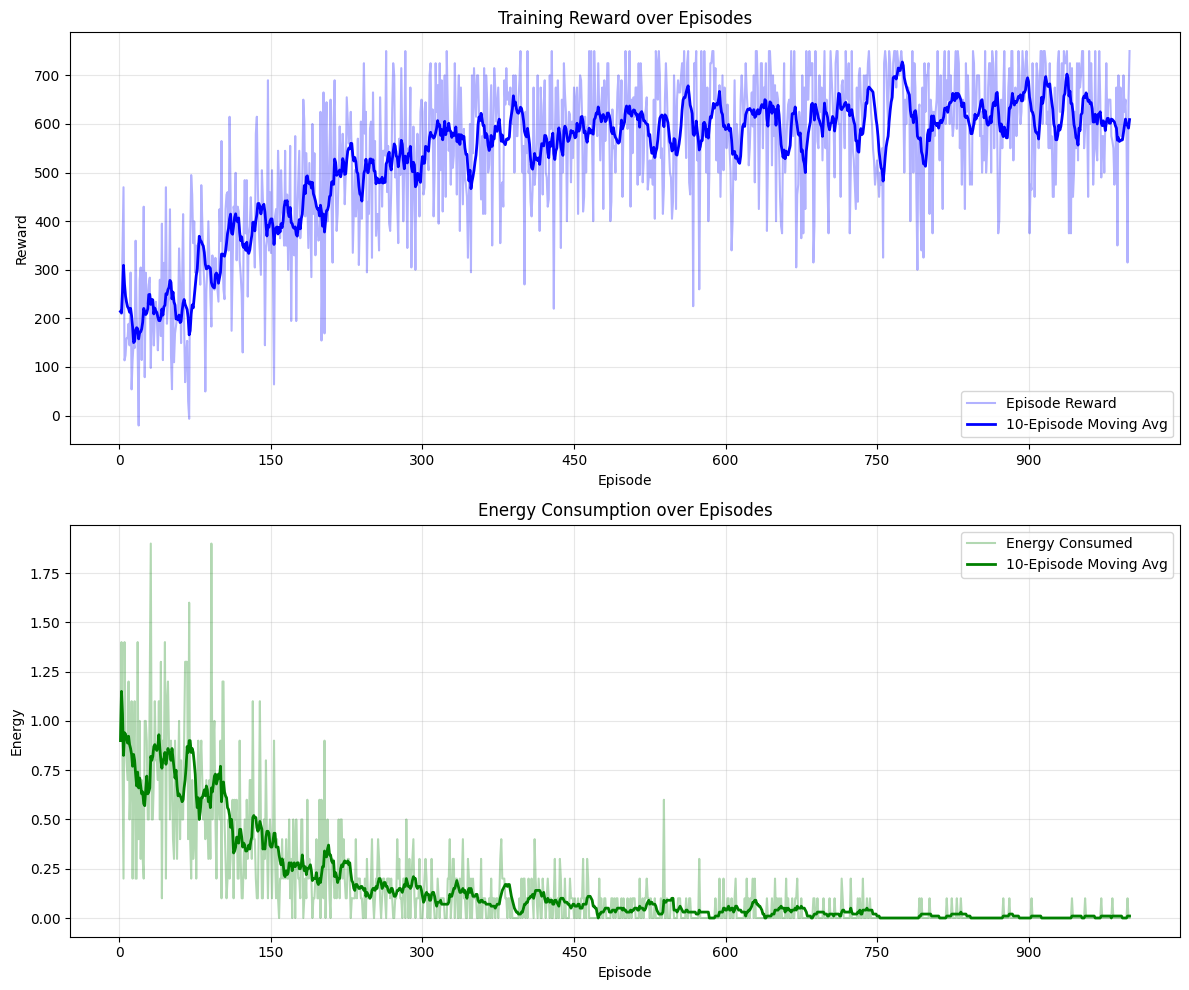

In [14]:
rew, energies=train_dueling_dqn_with_metrics(env)
fig = plot_training_metrics(rew, energies)
plt.savefig('training_metrics.png')
plt.show()